# <b> <u> KIBB Multiple Time Frame (MTF) Algo Trading Engine: ABMB

<i> <b> # Initialize and Fetch MTF Data

In [1]:
import os
import re
import talib
import random
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# === Initialize MT5 ===
mt5.initialize()
symbol = "ABMB"
#timezone = mt5.TIMEZONE

# === Define timeframes ===
timeframes = {
    "M15": mt5.TIMEFRAME_M30,
    "M30": mt5.TIMEFRAME_H1,
    "H1": mt5.TIMEFRAME_H4,
    "H4": mt5.TIMEFRAME_D1,
    "H12": mt5.TIMEFRAME_W1
}

# === Fetch OHLCV Data ===
def fetch_ohlcv(symbol, timeframe, bars=10000):
    
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    
    return df

df_M15 = fetch_ohlcv(symbol, timeframes["M15"], 21000)
df_M30 = fetch_ohlcv(symbol, timeframes["M30"], 13000)
df_H1  = fetch_ohlcv(symbol, timeframes["H1"], 8000)
df_H4 = fetch_ohlcv(symbol, timeframes["H4"], 5000)
df_H12 = fetch_ohlcv(symbol, timeframes["H12"], 3000)

for df in [df_M15, df_M30, df_H1, df_H4,df_H12]:
    if 'real_volume' in df.columns:
        df.drop(columns='real_volume', inplace=True)

column_rename_map = {
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'tick_volume': 'Volume',
    'spread': 'Spread'
}

for df in [df_M15, df_M30, df_H1, df_H4, df_H12]:
    df.rename(columns=column_rename_map, inplace=True)

for df in [df_M15, df_M30, df_H1, df_H4, df_H12]:
    df.reset_index(inplace=True)
    df.rename(columns={'time': 'Datetime'}, inplace=True)
    df.set_index('Datetime', inplace=True)

print(df_M15)
print(df_M15)
print(df_H1)
print(df_H4)
print(df_H12)


                     Open  High   Low  Close  Volume  Spread
Datetime                                                    
2018-05-28 11:00:00  4.28  4.29  4.28   4.28      30       0
2018-05-28 11:30:00  4.28  4.28  4.24   4.27      55       0
2018-05-28 12:00:00  4.27  4.27  4.25   4.27      15       0
2018-05-28 14:30:00  4.26  4.27  4.24   4.24      74       0
2018-05-28 15:00:00  4.24  4.30  4.22   4.29     134       0
...                   ...   ...   ...    ...     ...     ...
2025-08-06 09:30:00  4.62  4.62  4.59   4.59      69      10
2025-08-06 10:00:00  4.59  4.60  4.59   4.59      45      10
2025-08-06 10:30:00  4.59  4.62  4.59   4.60     114      10
2025-08-06 11:00:00  4.60  4.63  4.60   4.63      91      10
2025-08-06 11:30:00  4.64  4.65  4.62   4.64      89      10

[21000 rows x 6 columns]
                     Open  High   Low  Close  Volume  Spread
Datetime                                                    
2018-05-28 11:00:00  4.28  4.29  4.28   4.28      30       

<i> <b> # Add Indicators (SMA, RSI, Volume Spike) + Stop Loss and Take Profit

In [2]:
# Uptrend = slope > 0 and p-value < 0.05
# → So Not_Up_Trending = if any window fails this condition.
# Downtrend = slope < 0 and p-value < 0.05
# → So Not_Down_Trending = if any window fails this condition.

# === Function for slope & p-value ===
def regression(prices):
    prices = prices.dropna()
    if len(prices) < 2:
        return np.nan, np.nan
    X = sm.add_constant(np.arange(len(prices)))
    y = prices.values
    try:
        model = sm.OLS(y, X).fit()
        return model.params[1], model.pvalues[1]
    except:
        return np.nan, np.nan

# === Parameters ===
trend_windows = [8, 13, 21]
pval_thresh = 0.11

# === Rolling Regression ===
for w in trend_windows:
    df_H12[f'Slope_{w}'] = df_H12['Close'].rolling(w).apply(lambda x: regression(x)[0], raw=False)
    df_H12[f'Pval_{w}']  = df_H12['Close'].rolling(w).apply(lambda x: regression(x)[1], raw=False)

# === Not Up Trending ===
not_uptrend_list = []
for w in trend_windows:
    condition = (df_H12[f'Slope_{w}'] <= 0) | (df_H12[f'Pval_{w}'] >= pval_thresh)
    not_uptrend_list.append(condition)
df_H12['Not_Up_Trending'] = np.logical_or.reduce(not_uptrend_list)

# === Not Down Trending ===
not_downtrend_list = []
for w in trend_windows:
    condition = (df_H12[f'Slope_{w}'] >= 0) | (df_H12[f'Pval_{w}'] >= pval_thresh)
    not_downtrend_list.append(condition)
df_H12['Not_Down_Trending'] = np.logical_or.reduce(not_downtrend_list)

# === Up Trending (strong, confirmed trend) ===
uptrend_list = []
for w in trend_windows:
    condition = (df_H12[f'Slope_{w}'] > 0) & (df_H12[f'Pval_{w}'] < pval_thresh)
    uptrend_list.append(condition)
df_H12['Up_Trending'] = np.logical_and.reduce(uptrend_list)

# === Down Trending (strong, confirmed trend) ===
downtrend_list = []
for w in trend_windows:
    condition = (df_H12[f'Slope_{w}'] < 0) & (df_H12[f'Pval_{w}'] < pval_thresh)
    downtrend_list.append(condition)
df_H12['Down_Trending'] = np.logical_and.reduce(downtrend_list)

print(df_H12)


            Open  High   Low  Close  Volume  Spread   Slope_8    Pval_8  \
Datetime                                                                  
2017-09-24  3.95  3.95  3.79   3.90    1822       0       NaN       NaN   
2017-10-01  3.90  3.90  3.81   3.83    1269       0       NaN       NaN   
2017-10-08  3.86  3.91  3.82   3.90    2667       0       NaN       NaN   
2017-10-15  3.85  3.88  3.69   3.69    2709       0       NaN       NaN   
2017-10-22  3.75  3.83  3.65   3.81    2555       0       NaN       NaN   
...          ...   ...   ...    ...     ...     ...       ...       ...   
2025-07-06  4.41  4.57  4.36   4.53    5908      10  0.011310  0.547108   
2025-07-13  4.53  4.58  4.42   4.50    6289      10  0.023095  0.244470   
2025-07-20  4.50  4.54  4.48   4.50    5908      10  0.029167  0.148987   
2025-07-27  4.50  4.54  4.46   4.54    5573      10  0.048452  0.004941   
2025-08-03  4.50  4.66  4.49   4.64    2501      10  0.057024  0.001134   

            Slope_13   P

In [3]:
# === H4: Trend Bias ===
df_H4['RSI'] = talib.RSI(df_H4['Close'], timeperiod=13)
df_H4['RSI_SMA'] = df_H4['RSI'].rolling(window=13//4).mean()
df_H4['SMA21'] = talib.SMA(df_H4['Close'], timeperiod=21)
df_H4['BullBias'] = df_H4['Close'] > df_H4['SMA21']
df_H4['BearBias'] = df_H4['Close'] < df_H4['SMA21']
df_H4['Up_TP'] = df_H4['High'].rolling(21).max().shift(1)*1.011
df_H4['Dn_TP'] = df_H4['Low'].rolling(21).min().shift(1)*0.989

# === H1: Breakout & ATR Expanding ===
df_H1['Breakout'] = df_H1['Close'] > df_H1['High'].rolling(21).max().shift(1)
df_H1['Breakdown'] = df_H1['Close'] < df_H1['Low'].rolling(21).max().shift(1)
df_H1['Range'] = df_H1['High'] - df_H1['Low']
df_H1['ATR'] = df_H1['Range'].rolling(window=13).mean()
df_H1['ATR_SMA'] = df_H1['ATR'].rolling(window=13//4).mean()

# === M30: Slow Stochastic ===
slowk, slowd = talib.STOCH(df_M30['High'], df_M30['Low'], df_M30['Close'],
    fastk_period=13, slowk_period=13//4, slowk_matype=0, slowd_period=13//4, slowd_matype=0)

df_M30['Stoch_K'] = slowk
df_M30['Stoch_D'] = slowd

# === M15: COM and assume df has 'Close' prices
df_M15['CMO'] = talib.CMO(df_M15['Close'], timeperiod=13)
df_M15['CMO_SMA'] = df_M15['CMO'].rolling(window=13//4).mean()

df_M15['AD'] = ((df_M15['Close'] - df_M15['Low']) - (df_M15['High'] - df_M15['Close'])) / (df_M15['High'] - df_M15['Low']) * df_M15['Volume']
df_M15['AD'] = df_M15['AD'].cumsum()
df_M15['AD_SMA'] = df_M15['AD'].rolling(window=13//4).mean()

# === M15: Bullish Engulfing + Volume Spike ===
def calculate_heikin_ashi(df):
    
    ha_df = pd.DataFrame(index=df.index)
    
    # HA Close is the average of Open, High, Low, Close
    ha_df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    # HA Open is the average of the previous HA candle's Open and Close
    ha_open = [(df['Open'][0] + df['Close'][0]) / 2]  # First HA Open
    for i in range(1, len(df)):
        ha_open.append((ha_open[i-1] + ha_df['HA_Close'][i-1]) / 2)
    ha_df['HA_Open'] = ha_open
    # HA High is the max of High, HA_Open, HA_Close
    ha_df['HA_High'] = df[['High']].join(ha_df[['HA_Open', 'HA_Close']]).max(axis=1)

    # HA Low is the min of Low, HA_Open, HA_Close
    ha_df['HA_Low'] = df[['Low']].join(ha_df[['HA_Open', 'HA_Close']]).min(axis=1)

    return ha_df

ha_df = calculate_heikin_ashi(df_M15)
print(ha_df)

def detect_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close'):
    # Define pattern sets
    bullish_patterns = ['CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLENGULFING',
                        'CDLPIERCING', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDL3WHITESOLDIERS', 'CDL3INSIDE',
                        'CDLHIKKAKE', 'CDLABANDONEDBABY', 'CDLLADDERBOTTOM', 'CDLHOMINGPIGEON',
                        'CDLMORNINGSTAR', 'CDLMORNINGDOJISTAR']
    
    bearish_patterns = ['CDLSHOOTINGSTAR', 'CDLGRAVESTONEDOJI', 'CDLHANGINGMAN', 'CDL3BLACKCROWS', 'CDL3OUTSIDE',
                        'CDLEVENINGSTAR', 'CDLEVENINGDOJISTAR', 'CDLENGULFING', 'CDLHARAMI', 'CDLHARAMICROSS',
                        'CDLHIKKAKE', 'CDLUPSIDEGAP2CROWS', 'CDLSPINNINGTOP']
    
    # Prepare output
    df['Bullish_Reversal'] = False
    df['Bearish_Reversal'] = False

    for pattern in bullish_patterns + bearish_patterns:
        func = getattr(talib, pattern, None)
        if func:
            result = func(df[open_col], df[high_col], df[low_col], df[close_col])
            signal_col = f"{pattern}_Signal"
            df[signal_col] = result
            
            if pattern in bullish_patterns:
                df['Bullish_Reversal'] |= result > 0
            else:
                df['Bearish_Reversal'] |= result < 0

    return df

pattern_df = detect_candlestick_patterns(df_M15)
print(pattern_df)


# Labels
df_M15['Bull_Engulfing'] = (((ha_df['HA_Close'] > ha_df['HA_Open']) & (ha_df['HA_Close'] == ha_df['HA_High']) & (ha_df['HA_Open'] == ha_df['HA_Low'])) | (talib.CDLENGULFING(df_M15['Open'], df_M15['High'], df_M15['Low'], df_M15['Close']) > 0))
df_M15['Bear_Engulfing'] = (((ha_df['HA_Close'] < ha_df['HA_Open']) & (ha_df['HA_Close'] == ha_df['HA_Low']) & (ha_df['HA_Open'] == ha_df['HA_High'])) | (talib.CDLENGULFING(df_M15['Open'], df_M15['High'], df_M15['Low'], df_M15['Close']) < 0))
df_M15['Bullish_Reversal'] = pattern_df['Bullish_Reversal'].shift(1)
df_M15['Bearish_Reversal'] = pattern_df['Bearish_Reversal'].shift(1)
df_M15['CMO_Improving'] = df_M15['CMO']  > df_M15['CMO_SMA'] 
df_M15['CMO_Weakening'] = df_M15['CMO']  < df_M15['CMO_SMA']
df_M15['CMO_Overbought'] = (df_M15['CMO'] > 41)
df_M15['CMO_Oversold'] = (df_M15['CMO'] < -41)
df_M15['AD_Accumulation'] = df_M15['AD'] > df_M15['AD_SMA']
df_M15['AD_Distribution'] = df_M15['AD'] < df_M15['AD_SMA']
df_M15['VolumeSpike'] = df_M15['Volume'] > df_M15['Volume'].rolling(21).mean()
df_M15['Up_SL'] = df_M15['Low'].rolling(5).min().shift(1)*0.989
df_M15['Dn_SL'] = df_M15['High'].rolling(5).max().shift(1)*1.011

print(df_M15)
print(df_M30)
print(df_H1)
print(df_H4)

C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\4058979394.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ha_open = [(df['Open'][0] + df['Close'][0]) / 2]  # First HA Open
C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\4058979394.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ha_open.append((ha_open[i-1] + ha_df['HA_Close'][i-1]) / 2)


                     HA_Close   HA_Open   HA_High    HA_Low
Datetime                                                   
2018-05-28 11:00:00    4.2825  4.280000  4.290000  4.280000
2018-05-28 11:30:00    4.2675  4.281250  4.281250  4.240000
2018-05-28 12:00:00    4.2650  4.274375  4.274375  4.250000
2018-05-28 14:30:00    4.2525  4.269687  4.270000  4.240000
2018-05-28 15:00:00    4.2625  4.261094  4.300000  4.220000
...                       ...       ...       ...       ...
2025-08-06 09:30:00    4.6050  4.606463  4.620000  4.590000
2025-08-06 10:00:00    4.5925  4.605732  4.605732  4.590000
2025-08-06 10:30:00    4.6000  4.599116  4.620000  4.590000
2025-08-06 11:00:00    4.6150  4.599558  4.630000  4.599558
2025-08-06 11:30:00    4.6375  4.607279  4.650000  4.607279

[21000 rows x 4 columns]
                     Open  High   Low  Close  Volume  Spread        CMO  \
Datetime                                                                  
2018-05-28 11:00:00  4.28  4.29  4.28   4.28

<i> <b> # Merge All Timeframes into M15

In [4]:
# Rename indexes for merging
df_M15.index.name = 'Datetime'
df_M30.index.name = 'Datetime'
df_H1.index.name = 'Datetime'
df_H4.index.name = 'Datetime'
df_H12.index.name = 'Datetime'

# Resample to 15-min to align
df_M30_ff = df_M30[['Stoch_K', 'Stoch_D']].resample('15min').ffill()
df_H1_ff = df_H1[['ATR', 'ATR_SMA', 'Range', 'Breakout', 'Breakdown']].resample('15min').ffill()
df_H4_ff = df_H4[['RSI', 'RSI_SMA', 'SMA21', 'BullBias', 'BearBias', 'Up_TP', 'Dn_TP']].resample('15min').ffill()
df_H12_ff = df_H12[['Not_Up_Trending', 'Not_Down_Trending', 'Up_Trending', 'Down_Trending']].resample('15min').ffill()

# Merge into M15
df_all = df_M15.copy()
df_all = df_all.merge(df_M30_ff, how='left', left_index=True, right_index=True)
df_all = df_all.merge(df_H1_ff, how='left', left_index=True, right_index=True)
df_all = df_all.merge(df_H4_ff, how='left', left_index=True, right_index=True)
df_all = df_all.merge(df_H12_ff, how='left', left_index=True, right_index=True)
df_all = df_all.ffill()

print(df_all)


                     Open  High   Low  Close  Volume  Spread        CMO  \
Datetime                                                                  
2018-05-28 11:00:00  4.28  4.29  4.28   4.28      30       0        NaN   
2018-05-28 11:30:00  4.28  4.28  4.24   4.27      55       0        NaN   
2018-05-28 12:00:00  4.27  4.27  4.25   4.27      15       0        NaN   
2018-05-28 14:30:00  4.26  4.27  4.24   4.24      74       0        NaN   
2018-05-28 15:00:00  4.24  4.30  4.22   4.29     134       0        NaN   
...                   ...   ...   ...    ...     ...     ...        ...   
2025-08-06 09:30:00  4.62  4.62  4.59   4.59      69      10   5.224504   
2025-08-06 10:00:00  4.59  4.60  4.59   4.59      45      10   5.224504   
2025-08-06 10:30:00  4.59  4.62  4.59   4.60     114      10  10.487862   
2025-08-06 11:00:00  4.60  4.63  4.60   4.63      91      10  24.173666   
2025-08-06 11:30:00  4.64  4.65  4.62   4.64      89      10  28.141101   

                       C

C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\1304208997.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all = df_all.ffill()


<i> <b> # Final Entry & Exit Signal Logic

In [5]:
df_all['Entry_Long'] = (
    ((df_all['Up_Trending'] == True) | (df_all['Not_Down_Trending'] == True)) & 
    ((df_all['BullBias'] == True) & (df_all['RSI'] > df_all['RSI_SMA'])) &
    ((df_all['ATR'] > df_all['ATR_SMA']) & (df_all['Breakout'] == True)) &
    (((df_all['Stoch_K'] > df_all['Stoch_D']) & (df_all['Stoch_D'] <= 81)) |
    (((df_all['Bull_Engulfing'] == True) & (df_all['Bullish_Reversal'] == True)) & (df_all['VolumeSpike'] == True) & 
     (df_all['CMO_Overbought'] == False) & (df_all['CMO_Improving'] == True) & (df_all['AD_Accumulation'] == True)))
)

df_all['Close_Long'] = (
    (df_all['Stoch_D'] > 81) &
    (df_all['Stoch_K'] < df_all['Stoch_D'])
)

df_all['Entry_Short'] = (
    ((df_all['Down_Trending'] == True) | (df_all['Not_Up_Trending'] == True)) & 
    ((df_all['BearBias'] == True) & (df_all['RSI'] < df_all['RSI_SMA'])) &
    ((df_all['ATR'] > df_all['ATR_SMA']) & (df_all['Breakdown'] == True)) &
    (((df_all['Stoch_K'] < df_all['Stoch_D']) & (df_all['Stoch_D'] >= 19)) |
    (((df_all['Bear_Engulfing'] == True) & (df_all['Bearish_Reversal'] == True)) & (df_all['VolumeSpike'] == True) & 
     (df_all['CMO_Oversold'] == False) & (df_all['CMO_Weakening'] == True) & (df_all['AD_Distribution'] == True)))
)

df_all['Close_Short'] = (
    (df_all['Stoch_D'] < 19) &
    (df_all['Stoch_K'] > df_all['Stoch_D'])
)

print(df_all)


                     Open  High   Low  Close  Volume  Spread        CMO  \
Datetime                                                                  
2018-05-28 11:00:00  4.28  4.29  4.28   4.28      30       0        NaN   
2018-05-28 11:30:00  4.28  4.28  4.24   4.27      55       0        NaN   
2018-05-28 12:00:00  4.27  4.27  4.25   4.27      15       0        NaN   
2018-05-28 14:30:00  4.26  4.27  4.24   4.24      74       0        NaN   
2018-05-28 15:00:00  4.24  4.30  4.22   4.29     134       0        NaN   
...                   ...   ...   ...    ...     ...     ...        ...   
2025-08-06 09:30:00  4.62  4.62  4.59   4.59      69      10   5.224504   
2025-08-06 10:00:00  4.59  4.60  4.59   4.59      45      10   5.224504   
2025-08-06 10:30:00  4.59  4.62  4.59   4.60     114      10  10.487862   
2025-08-06 11:00:00  4.60  4.63  4.60   4.63      91      10  24.173666   
2025-08-06 11:30:00  4.64  4.65  4.62   4.64      89      10  28.141101   

                       C

<i> <b> # Strategy Performance

In [ ]:
# === Step 1: Create Signal Columns ===

# Initialize signal columns
df_all['LongOnly_Signal'] = 0
df_all['ShortOnly_Signal'] = 0

# Position flags
long_position = False
short_position = False

# Iterate using iloc for position-based access
for i in range(len(df_all)):
    row = df_all.iloc[i]
    if row['Entry_Long']:
        long_position = True
    elif row['Close_Long']:
        long_position = False
    if row['Entry_Short']:
        short_position = True
    elif row['Close_Short']:
        short_position = False

    df_all.iloc[i, df_all.columns.get_loc('LongOnly_Signal')] = 1 if long_position else 0
    df_all.iloc[i, df_all.columns.get_loc('ShortOnly_Signal')] = -1 if short_position else 0

# Combine signals
df_all['LongShort_Signal'] = df_all['LongOnly_Signal'] + df_all['ShortOnly_Signal']
print(df_all)

# === Step 2: Calculate Return ===
df_all['Return'] = np.log(df_all['Close']/df_all['Close'].shift(1))

# === Step 3: Calculate Strategy Performance ===
df_all['LongOnly_Perf'] = df_all['LongOnly_Signal'].shift(1) * df_all['Return']
df_all['ShortOnly_Perf'] = df_all['ShortOnly_Signal'].shift(1) * df_all['Return']
df_all['LongShort_Perf'] = df_all['LongShort_Signal'].shift(1) * df_all['Return']

df_all['LongOnly_Cum'] = df_all['LongOnly_Perf'].cumsum()
df_all['ShortOnly_Cum'] = df_all['ShortOnly_Perf'].cumsum()
df_all['LongShort_Cum'] = df_all['LongShort_Perf'].cumsum()
df_all['BuyHold_Cum'] = df_all['Return'].cumsum()

plt.figure(figsize=(13, 8))
plt.plot(df_all['LongOnly_Cum'], label='Long Only')
plt.plot(df_all['ShortOnly_Cum'], label='Short Only')
plt.plot(df_all['LongShort_Cum'], label='Long & Short')
plt.plot(df_all['BuyHold_Cum'], label='Buy & Hold')
plt.legend()
plt.title('Cumulative Strategy Performance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Drawdown Function
def compute_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd, dd.min()

df_all['LongOnly_DD'], long_dd = compute_drawdown(df_all['LongOnly_Cum'])
df_all['ShortOnly_DD'], short_dd = compute_drawdown(df_all['ShortOnly_Cum'])
df_all['LongShort_DD'], longshort_dd = compute_drawdown(df_all['LongShort_Cum'])
df_all['BuyHold_DD'], buyhold_dd = compute_drawdown(df_all['BuyHold_Cum'])

# Sharpe Ratio (Assume No Risk-Free Rate)
def sharpe(series, bars_per_year=96 * 252):
    return (series.mean() / series.std()) * np.sqrt(bars_per_year)

long_sharpe = sharpe(df_all['LongOnly_Perf'])
short_sharpe = sharpe(df_all['ShortOnly_Perf'])
longshort_sharpe = sharpe(df_all['LongShort_Perf'])
buyhold_sharpe = sharpe(df_all['Return'])

# Win Rate (Profitable Bars)
long_win = (df_all['LongOnly_Perf'] > 0).mean()
short_win = (df_all['ShortOnly_Perf'] > 0).mean()
longshort_win = (df_all['LongShort_Perf'] > 0).mean()
buyhold_win = (df_all['Return'] > 0).mean()


summary = pd.DataFrame({
    'Strategy': ['Long Only', 'Short Only', 'Long+Short', 'Buy & Hold'],
    'Total Return': [
        df_all['LongOnly_Cum'].iloc[-1] - 1,
        df_all['ShortOnly_Cum'].iloc[-1] - 1,
        df_all['LongShort_Cum'].iloc[-1] - 1,
        df_all['BuyHold_Cum'].iloc[-1] - 1,
    ],
    'Max Drawdown': [
        long_dd,
        short_dd,
        longshort_dd,
        buyhold_dd,
    ],
    'Sharpe Ratio': [
        long_sharpe,
        short_sharpe,
        longshort_sharpe,
        buyhold_sharpe,
    ],
    'Win Rate': [
        long_win,
        short_win,
        longshort_win,
        buyhold_win,
    ]
})

# Format nicely
summary.set_index('Strategy', inplace=True)
summary = summary.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)
print(summary)


<i> <b> # Strategy Performance: Long-Only

In [7]:
trades = []
position_open = False

for i in range(len(df_all)):
    row = df_all.iloc[i]

    if not position_open and row['Entry_Long']:
        entry_idx = i
        entry_time = df_all.index[i]
        entry_price = df_all.iloc[i + 1]['Open'] if i + 1 < len(df_all) else row['Close']
        sl = row['Up_SL']
        tp = row['Up_TP']
        position_open = True
        continue

    if position_open:
        low = row['Low']
        high = row['High']
        exit_price = None
        exit_reason = None

        # SL Hit
        if low <= sl:
            exit_price = sl
            exit_reason = "Up_SL"

        # TP Hit
        elif high > tp:
            exit_price = tp
            exit_reason = "Up_TP"

        # Signal Exit
        elif row['Close_Long']:
            exit_price = row['Open']
            exit_reason = "Close_Signal"

        if exit_price:
            pnl = exit_price - entry_price  # LONG: buy low, sell high
            trades.append({
                'Entry Time': entry_time,
                'Exit Time': df_all.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Return': pnl / entry_price,
                'Exit Reason': exit_reason
            })
            #print(f"🟢 LONG TRADE: Entry={entry_time}, Exit={df_all.index[i]}, PnL={pnl:.4f}")
            position_open = False


📊 Strategy vs Buy & Hold Performance
Strategy Total Return: 35.17%
Buy & Hold Return:     8.08%
Win Rate:              68.66%
Average Trade Return:  0.0046
Sharpe Ratio:          0.35


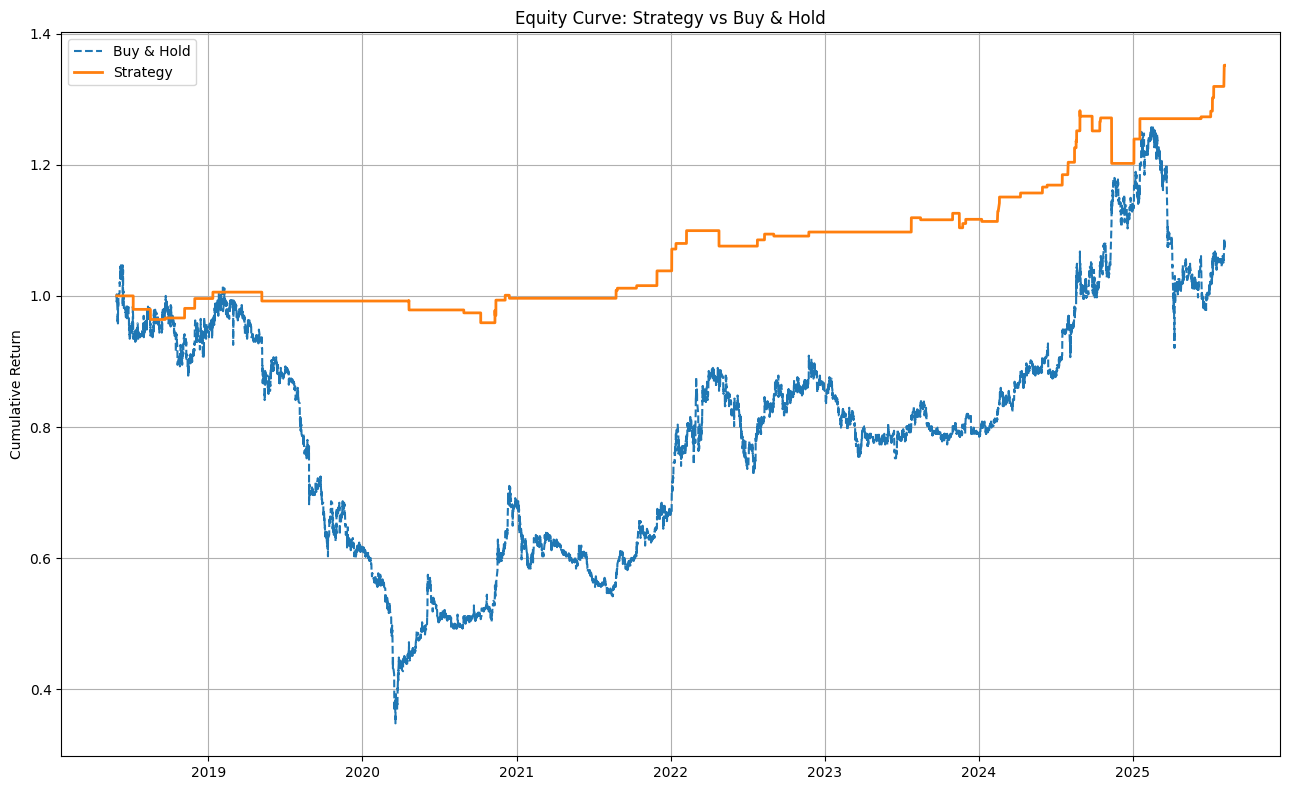

In [8]:
# Convert Trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df['Return'] = trades_df['PnL'] / trades_df['Entry Price']

# Strategy Equity Curve
trades_df['Cum_Return'] = (1 + trades_df['Return']).cumprod()

# Buy & Hold Benchmark
buy_price = df_all['Close'].iloc[0]
df_all['BuyHold_Return'] = np.log(df_all['Close'] / buy_price)

# Metrics Summary
strategy_total_return = trades_df['Cum_Return'].iloc[-1] - 1
strategy_win_rate = (trades_df['PnL'] > 0).mean()
strategy_avg_return = trades_df['Return'].mean()
strategy_sharpe = trades_df['Return'].mean() / trades_df['Return'].std()

print("📊 Strategy vs Buy & Hold Performance")
print(f"Strategy Total Return: {strategy_total_return:.2%}")
print(f"Buy & Hold Return:     {df_all['BuyHold_Return'].iloc[-1]:.2%}")
print(f"Win Rate:              {strategy_win_rate:.2%}")
print(f"Average Trade Return:  {strategy_avg_return:.4f}")
print(f"Sharpe Ratio:          {strategy_sharpe:.2f}")

# Plot Equity Curve
df_all['Strategy_Equity'] = 1.0  # Base value = 1.0
df_all['BuyHold_Return'] = df_all['Close'] / buy_price

# Loop through trades and propagate cumulative return forward
for i in range(len(trades_df)):
    exit_time = trades_df['Exit Time'].iloc[i]
    cum_return = trades_df['Cum_Return'].iloc[i]

    # Apply to all times >= exit_time
    df_all.loc[df_all.index >= exit_time, 'Strategy_Equity'] = cum_return

df_all['Strategy_Equity'] = df_all['Strategy_Equity'].ffill()

plt.figure(figsize=(13, 8))
plt.plot(df_all.index, df_all['BuyHold_Return'], label='Buy & Hold', linestyle='--')
plt.plot(df_all.index, df_all['Strategy_Equity'], label='Strategy', linewidth=2)
plt.title("Equity Curve: Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<i> <b> # Strategy Perfoamance: Short-Only

In [9]:
trades = []
position_open = False

for i in range(len(df_all)):
    row = df_all.iloc[i]

    # === Entry for Short ===
    if not position_open and row['Entry_Short']:
        entry_idx = i
        entry_time = df_all.index[i]
        entry_price = df_all.iloc[i + 1]['Open'] if i + 1 < len(df_all) else row['Close']
        sl = row['Dn_SL']
        tp = row['Dn_TP']
        position_open = True
        continue

    if position_open:
        high = row['High']
        low = row['Low']
        exit_price = None
        exit_reason = None

        # === SL Hit (price goes up beyond stop)
        if high >= sl:
            exit_price = sl
            exit_reason = "Dn_SL"

        # === TP Hit (price drops to profit level)
        elif low < tp:
            exit_price = tp
            exit_reason = "Dn_TP"

        # === Signal Exit
        elif row['Close_Short']:
            exit_price = row['Open']
            exit_reason = "Close_Signal"

        if exit_price:
            pnl = entry_price - exit_price  # short: sell high, buy back low
            trades.append({
                'Entry Time': entry_time,
                'Exit Time': df_all.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Return': pnl / entry_price,
                'Exit Reason': exit_reason
            })
            #print(f"🔻 SHORT TRADE: Entry={entry_time}, Exit={df_all.index[i]}, PnL={pnl:.4f}")
            position_open = False


📊 Strategy vs Buy & Hold Performance
Strategy Total Return: 129.93%
Buy & Hold Return:     8.08%
Win Rate:              71.00%
Average Trade Return:  0.0043
Sharpe Ratio:          0.24


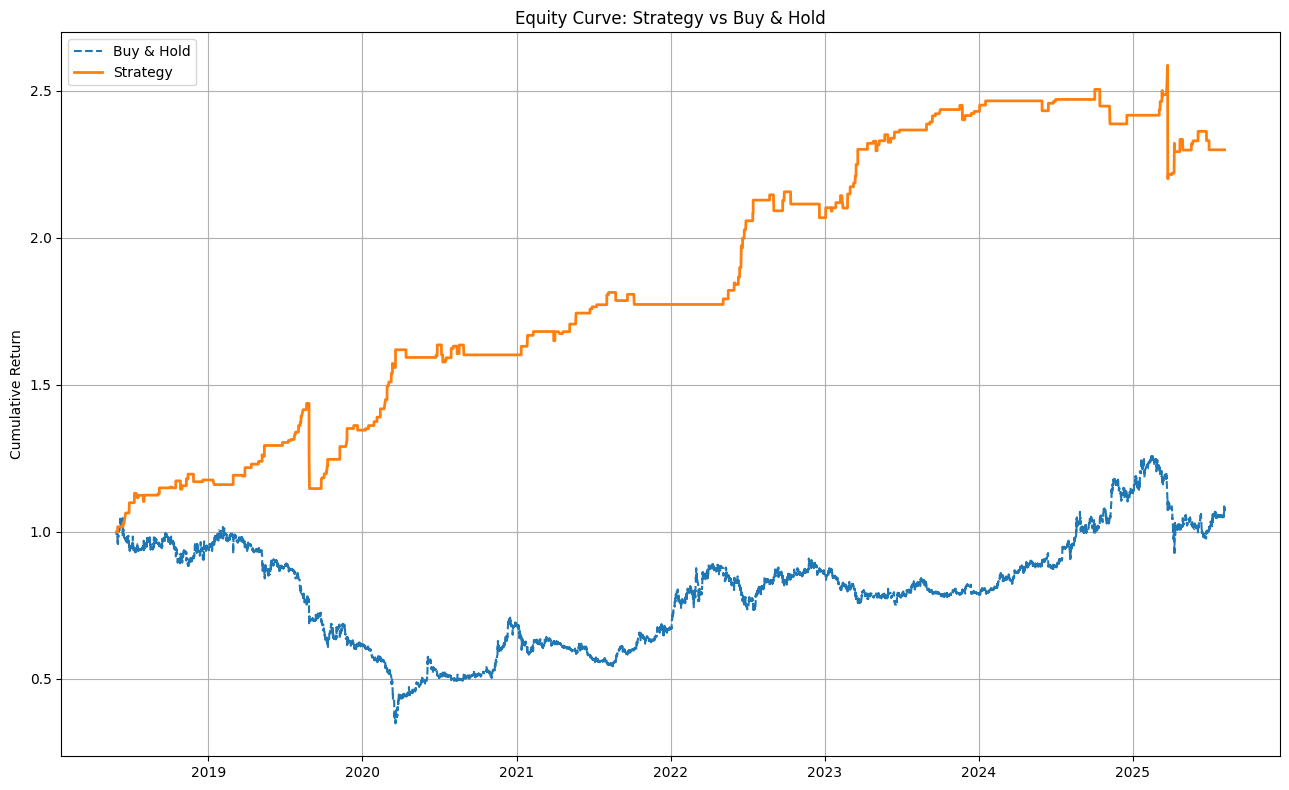

In [10]:
# Convert Trades to DataFrame
trades_df = pd.DataFrame(trades)
trades_df['Return'] = trades_df['PnL'] / trades_df['Entry Price']

# Strategy Equity Curve
trades_df['Cum_Return'] = (1 + trades_df['Return']).cumprod()

# Buy & Hold Benchmark
buy_price = df_all['Close'].iloc[0]
df_all['BuyHold_Return'] = np.log(df_all['Close'] / buy_price)

# Metrics Summary
strategy_total_return = trades_df['Cum_Return'].iloc[-1] - 1
strategy_win_rate = (trades_df['PnL'] > 0).mean()
strategy_avg_return = trades_df['Return'].mean()
strategy_sharpe = trades_df['Return'].mean() / trades_df['Return'].std()

print("📊 Strategy vs Buy & Hold Performance")
print(f"Strategy Total Return: {strategy_total_return:.2%}")
print(f"Buy & Hold Return:     {df_all['BuyHold_Return'].iloc[-1]:.2%}")
print(f"Win Rate:              {strategy_win_rate:.2%}")
print(f"Average Trade Return:  {strategy_avg_return:.4f}")
print(f"Sharpe Ratio:          {strategy_sharpe:.2f}")

# Plot Equity Curve
df_all['Strategy_Equity'] = 1.0  # Base value = 1.0
df_all['BuyHold_Return'] = df_all['Close'] / buy_price

# Loop through trades and propagate cumulative return forward
for i in range(len(trades_df)):
    exit_time = trades_df['Exit Time'].iloc[i]
    cum_return = trades_df['Cum_Return'].iloc[i]

    # Apply to all times >= exit_time
    df_all.loc[df_all.index >= exit_time, 'Strategy_Equity'] = cum_return

df_all['Strategy_Equity'] = df_all['Strategy_Equity'].ffill()

plt.figure(figsize=(13, 8))
plt.plot(df_all.index, df_all['BuyHold_Return'], label='Buy & Hold', linestyle='--')
plt.plot(df_all.index, df_all['Strategy_Equity'], label='Strategy', linewidth=2)
plt.title("Equity Curve: Strategy vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Consolidated BackTesting 

1st DataFrame                  Datetime  Open  High   Low  Close  Volume  Spread        CMO  \
0     2018-05-28 11:00:00  4.28  4.29  4.28   4.28      30       0        NaN   
1     2018-05-28 11:30:00  4.28  4.28  4.24   4.27      55       0        NaN   
2     2018-05-28 12:00:00  4.27  4.27  4.25   4.27      15       0        NaN   
3     2018-05-28 14:30:00  4.26  4.27  4.24   4.24      74       0        NaN   
4     2018-05-28 15:00:00  4.24  4.30  4.22   4.29     134       0        NaN   
...                   ...   ...   ...   ...    ...     ...     ...        ...   
20995 2025-08-06 09:30:00  4.62  4.62  4.59   4.59      69      10   5.224504   
20996 2025-08-06 10:00:00  4.59  4.60  4.59   4.59      45      10   5.224504   
20997 2025-08-06 10:30:00  4.59  4.62  4.59   4.60     114      10  10.487862   
20998 2025-08-06 11:00:00  4.60  4.63  4.60   4.63      91      10  24.173666   
20999 2025-08-06 11:30:00  4.64  4.65  4.62   4.64      89      10  28.141101   

         CMO_

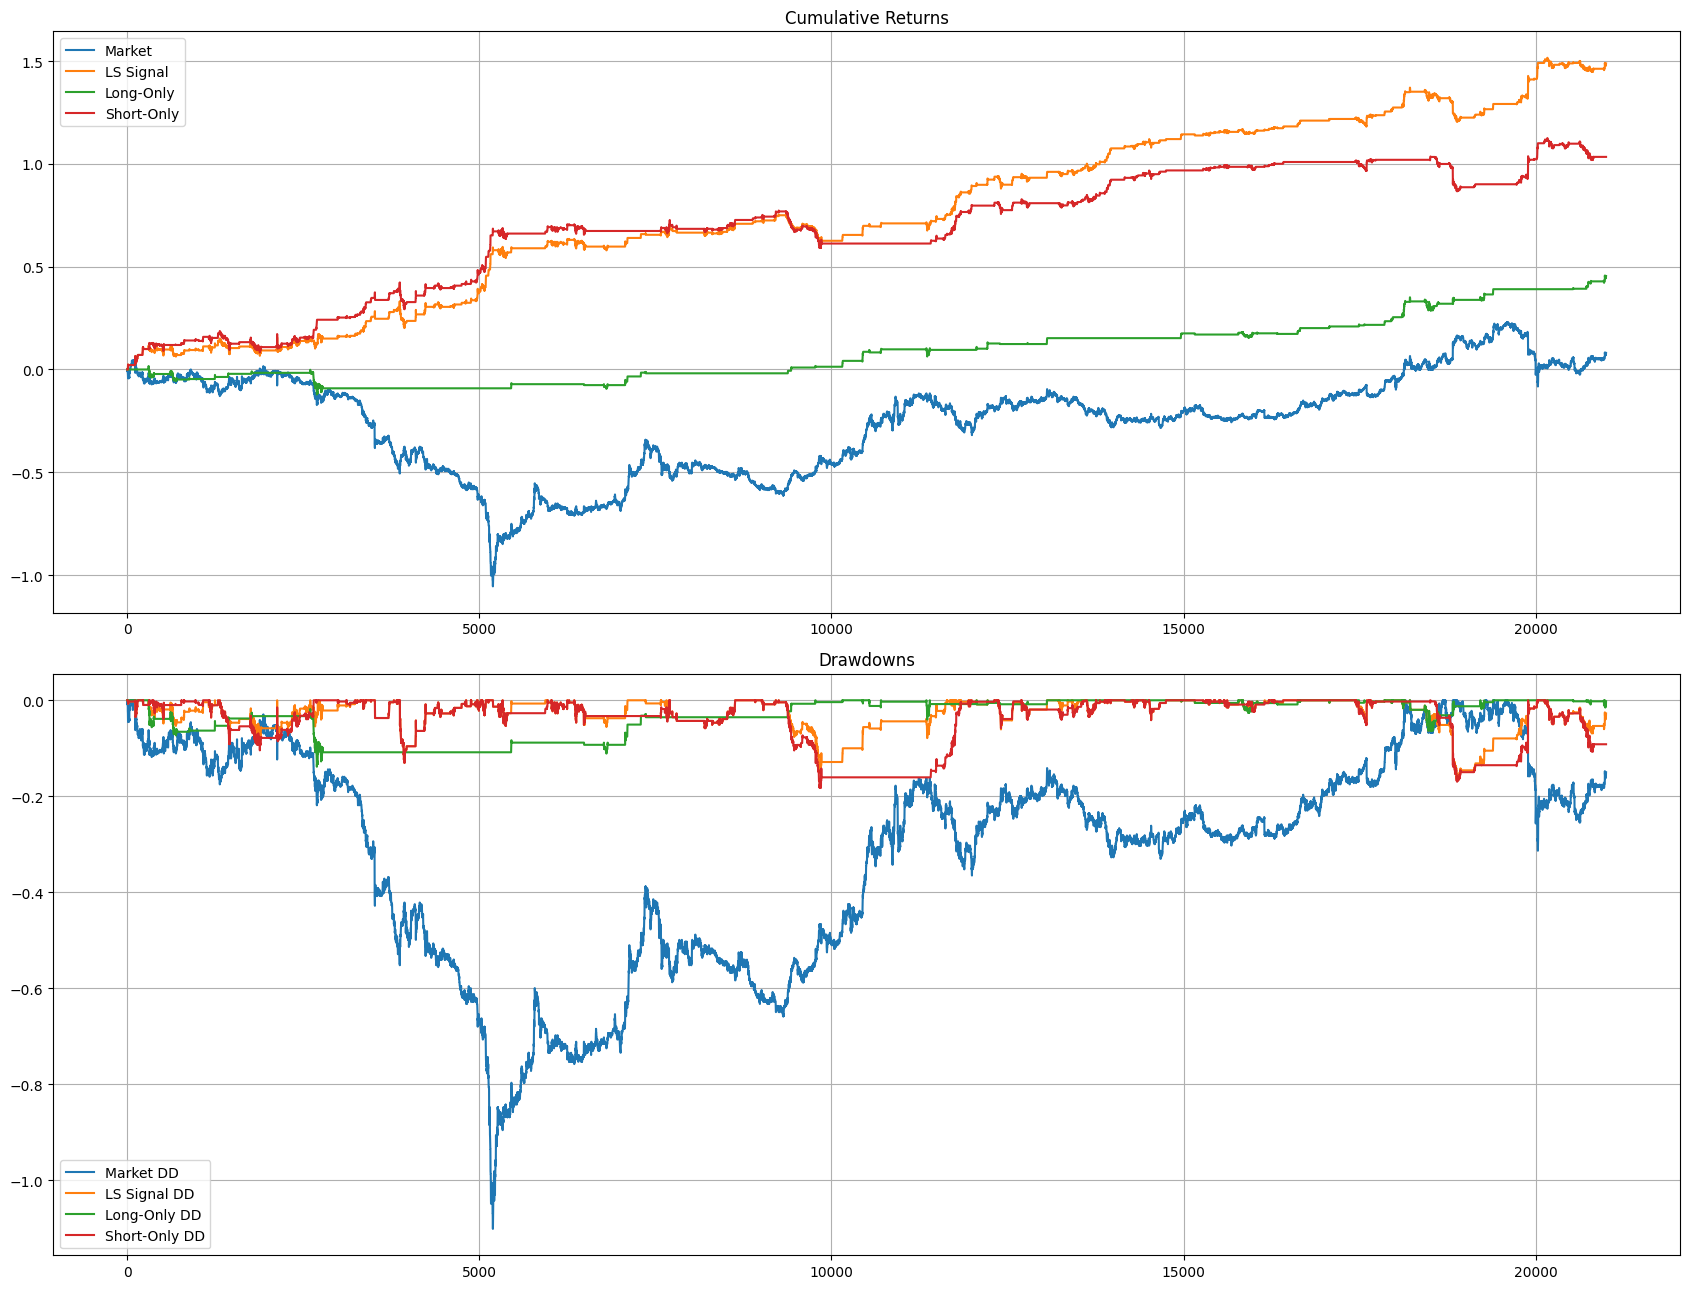

5th DataFrame                  Datetime  Open  High   Low  Close    Up_TP    Dn_TP    Up_SL  \
0     2018-05-28 11:00:00  4.28  4.29  4.28   4.28  4.48884  4.01534      NaN   
1     2018-05-28 11:30:00  4.28  4.28  4.24   4.27  4.48884  4.01534      NaN   
2     2018-05-28 12:00:00  4.27  4.27  4.25   4.27  4.48884  4.01534      NaN   
3     2018-05-28 14:30:00  4.26  4.27  4.24   4.24  4.48884  4.01534      NaN   
4     2018-05-28 15:00:00  4.24  4.30  4.22   4.29  4.48884  4.01534      NaN   
...                   ...   ...   ...   ...    ...      ...      ...      ...   
20995 2025-08-06 09:30:00  4.62  4.62  4.59   4.59  4.63038  4.31204  4.53951   
20996 2025-08-06 10:00:00  4.59  4.60  4.59   4.59  4.63038  4.31204  4.53951   
20997 2025-08-06 10:30:00  4.59  4.62  4.59   4.60  4.63038  4.31204  4.53951   
20998 2025-08-06 11:00:00  4.60  4.63  4.60   4.63  4.63038  4.31204  4.53951   
20999 2025-08-06 11:30:00  4.64  4.65  4.62   4.64  4.63038  4.31204  4.53951   

         Dn_S

Loading ITables v2.4.3 from the internet... (need help?)


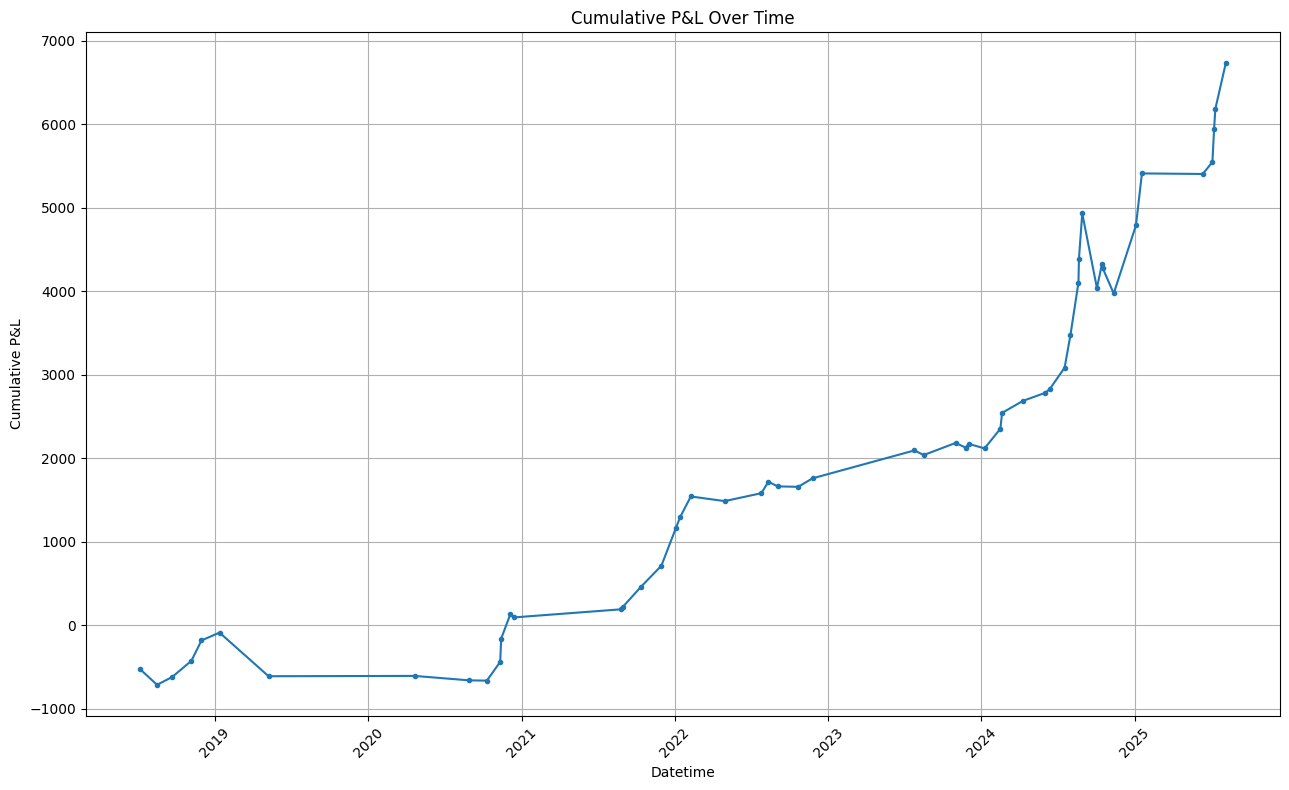

Backtest Performance Metrics
{'Win Rate (%)': 70.37, 'Average Win': np.float64(252.81), 'Average Loss': np.float64(-179.76), 'Reward-to-Risk Ratio': np.float64(1.41), 'Sharpe Ratio': np.float64(0.43), 'Total Trades': 54, 'Total P&L': np.float64(6730.55), 'Final Cumulative P&L': np.float64(6730.55)}


In [11]:
from datetime import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import TimeSeriesSplit

# === Load data ===
backtest_data = df_all.copy()
backtest_data.reset_index(inplace=True)
print("1st DataFrame", backtest_data)

# Add time-based features to merged_df
backtest_data['minute'] = backtest_data['Datetime'].dt.minute
backtest_data['hour'] = backtest_data['Datetime'].dt.hour
backtest_data['day'] = backtest_data['Datetime'].dt.day
backtest_data['dayofweek'] = backtest_data['Datetime'].dt.dayofweek
backtest_data['week'] = backtest_data['Datetime'].dt.isocalendar().week.astype(int)
backtest_data['month'] = backtest_data['Datetime'].dt.month
backtest_data['quarter'] = backtest_data['Datetime'].dt.quarter
backtest_data['year'] = backtest_data['Datetime'].dt.year
backtest_data['is_month_end'] = backtest_data['Datetime'].dt.is_month_end.astype(int)
backtest_data['is_month_start'] = backtest_data['Datetime'].dt.is_month_start.astype(int)
backtest_data['is_weekend'] = backtest_data['Datetime'].dt.dayofweek.isin([5, 6]).astype(int)

# ✅ Detect last 1 hour before weekend — Friday 23:00 UTC exactly
backtest_data['next_time'] = backtest_data['Datetime'].shift(-1)
backtest_data['gap_days'] = (backtest_data['next_time'] - backtest_data['Datetime']).dt.days
backtest_data['is_last_hour_before_weekend'] = (
    (backtest_data['dayofweek'] == 4) & (backtest_data['hour'] >= 19)
).astype(int)

cols_to_drop = [
    col for col in backtest_data.columns
    if col in ['next_time', 'gap_days', 'dayofweek', 'month', 'quarter', 'year', 
               'is_month_end', 'is_month_start', 'is_weekend']
]

# Drop from DataFrame
backtest_data.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"🧹 Dropped {len(cols_to_drop)} columns: {cols_to_drop}")

# Print sample and save
print("2nd DataFrame", backtest_data)
print("-" * 111)

# === Extract relevant columns ===
selected_columns = ['Datetime',
    'Open', 'High', 'Low', 'Close',
    'Up_TP', 'Dn_TP', 'Up_SL', 'Dn_SL',
    'LongShort_Signal',
    'LongOnly_Signal', 'ShortOnly_Signal',
    'is_last_hour_before_weekend', 'Spread'
]

data = backtest_data[selected_columns].copy()
print("3rd DataFrame", data)
print("-" * 111)

# === Compute Log Returns ===
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Cum_Returns'] = data['Returns'].cumsum()

# === Strategy Returns ===
data['LS_Signal_Returns'] = data['LongShort_Signal'].shift(1) * data['Returns']
data['LO_Signal_Returns'] = data['LongOnly_Signal'].shift(1) * data['Returns']
data['SO_Signal_Returns'] = data['ShortOnly_Signal'].shift(1) * data['Returns']  

# === Cumulative Returns ===
data['LS_Signal_Cum_Returns'] = data['LS_Signal_Returns'].cumsum()
data['LO_Signal_Cum_Returns'] = data['LO_Signal_Returns'].cumsum()
data['SO_Signal_Cum_Returns'] = data['SO_Signal_Returns'].cumsum()

# === Display Summary ===
print("4th DataFrame")
print(data[['Datetime',
    'Returns', 'Cum_Returns',
    'LS_Signal_Cum_Returns', 
    'LO_Signal_Cum_Returns', 'SO_Signal_Cum_Returns'
]])
print("-" * 111)

# === Drawdown Calculation ===
def calculate_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = cum_returns - peak
    return drawdown

# Compute drawdowns
data['Drawdown_Market'] = calculate_drawdown(data['Cum_Returns'])
data['Drawdown_LS'] = calculate_drawdown(data['LS_Signal_Cum_Returns'])
data['Drawdown_LO'] = calculate_drawdown(data['LO_Signal_Cum_Returns'])
data['Drawdown_SO'] = calculate_drawdown(data['SO_Signal_Cum_Returns'])

# === Maximum Drawdowns ===
max_dd = {
    "Market": data['Drawdown_Market'].min(),
    "LS": data['Drawdown_LS'].min(),
    "LO": data['Drawdown_LO'].min(),
    "SO": data['Drawdown_SO'].min(),
}

# === Sharpe Ratio Function ===
def sharpe_ratio(returns, periods_per_year=252):
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if returns.std() != 0 else 0

# === Sharpe Ratios ===L
sharpe = {
    "Market": sharpe_ratio(data['Returns'].dropna()),
    "LS": sharpe_ratio(data['LS_Signal_Returns'].dropna()),
    "LO": sharpe_ratio(data['LO_Signal_Returns'].dropna()),
    "SO": sharpe_ratio(data['SO_Signal_Returns'].dropna()),
}

# === Print Metrics ===
print("Maximum Drawdowns:")
for k, v in max_dd.items():
    print(f"{k:<10}: {v:.4%}")
print("\nSharpe Ratios:")
for k, v in sharpe.items():
    print(f"{k:<10}: {v:.4f}")

# === Visualization ===
plt.figure(figsize=(17, 13))

# --- Cumulative Returns Plot ---
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Cum_Returns'], label='Market')
plt.plot(data.index, data['LS_Signal_Cum_Returns'], label='LS Signal')
plt.plot(data.index, data['LO_Signal_Cum_Returns'], label='Long-Only')
plt.plot(data.index, data['SO_Signal_Cum_Returns'], label='Short-Only')
plt.title('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)

# --- Drawdown Plot ---
plt.subplot(2, 1, 2)
plt.plot(data.index, data['Drawdown_Market'], label='Market DD')
plt.plot(data.index, data['Drawdown_LS'], label='LS Signal DD')
plt.plot(data.index, data['Drawdown_LO'], label='Long-Only DD')
plt.plot(data.index, data['Drawdown_SO'], label='Short-Only DD')
plt.title('Drawdowns')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()

df = data.copy()
print("5th DataFrame", df)
print("-" * 111)

# Ensure 'Datetime' is datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Compute last hour before weekend
df['is_last_hour_before_weekend'] = (
    (df['Datetime'].dt.dayofweek == 4) &  # Friday
    (df['Datetime'].dt.hour >= 19)
).astype(int)

# Initialize trade tracking
trades = []
position = None

# === Configuration ===
initial_capital = 100000
print("initial_capital:", initial_capital)

lot_size = 5000.0
print("invested_lot_size:", lot_size)

scale_factor = 1
decimal_points = 2
transaction_cost_percentage_input = 0.015

EXECUTION_MODE = "open"  # choose: "open" or "close"

# Iterate from 2nd index
for i in range(2, len(df)):
    prev2 = df.iloc[i - 2]
    prev = df.iloc[i - 1]
    curr = df.iloc[i]

    prev_signal = prev2["LongOnly_Signal"] # LongShort_Signal, LongOnly_Signal
    curr_signal = prev["LongOnly_Signal"] # LongShort_Signal, ShortOnly_Signal
    exec_price = round(curr["Open"] if EXECUTION_MODE == "open" else prev["Close"], decimal_points)
    timestamp = curr["Datetime"]

    # Stop-loss and Take-profit check
    if position:
        if position["type"] == "Buy":
            rolling_sl = prev["Up_SL"]
            rolling_tp = prev["Up_TP"]
    
            if pd.notna(rolling_sl) and rolling_sl != 0 and curr["Low"] <= rolling_sl:
                exit_reason = "SL"
                exit_price = rolling_sl
            elif pd.notna(rolling_tp) and rolling_tp != 0 and curr["High"] > rolling_tp:
                exit_reason = "TP"
                exit_price = rolling_tp
            elif curr["is_last_hour_before_weekend"] == 1:
                exit_reason = "Weekend"
                exit_price = exec_price
            else:
                exit_reason = None
    
        elif position["type"] == "Sell":
            rolling_sl = prev["Dn_SL"]
            rolling_tp = prev["Dn_TP"]
    
            if pd.notna(rolling_sl) and rolling_sl != 0 and curr["High"] >= rolling_sl:
                exit_reason = "SL"
                exit_price = rolling_sl
            elif pd.notna(rolling_tp) and rolling_tp != 0 and curr["Low"] < rolling_tp:
                exit_reason = "TP"
                exit_price = rolling_tp
            elif curr["is_last_hour_before_weekend"] == 1:
                exit_reason = "Weekend"
                exit_price = exec_price
            else:
                exit_reason = None

        if exit_reason:
            exit_time = timestamp
            if position["type"] == "Buy":
                pnl = ((exit_price * (1 - transaction_cost_percentage_input / 100)) - position["entry_price"] * (1 + transaction_cost_percentage_input / 100)) * scale_factor * lot_size
            else:
                pnl = ((position["entry_price"] * (1 - transaction_cost_percentage_input / 100)) - exit_price * (1 + transaction_cost_percentage_input / 100)) * scale_factor * lot_size

            trades.append({
                "Entry Time": position["entry_time"],
                "Entry Price": position["entry_price"],
                "Exit Time": exit_time,
                "Exit Price": exit_price,
                "Type": position["type"],
                "Exit Reason": exit_reason,
                "P&L": round(pnl, 2)
            })
            position = None
            continue

    # Signal change → Close + Open
    if curr_signal != prev_signal:
        if position:
            exit_price = exec_price
            exit_time = timestamp
            if position["type"] == "Buy":
                pnl = ((exit_price * (1 - transaction_cost_percentage_input / 100)) - position["entry_price"] * (1 + transaction_cost_percentage_input / 100)) * scale_factor * lot_size
            else:
                pnl = ((position["entry_price"] * (1 - transaction_cost_percentage_input / 100)) - exit_price * (1 + transaction_cost_percentage_input / 100)) * scale_factor * lot_size

            trades.append({
                "Entry Time": position["entry_time"],
                "Entry Price": position["entry_price"],
                "Exit Time": exit_time,
                "Exit Price": exit_price,
                "Type": position["type"],
                "Exit Reason": "Reversal",
                "P&L": round(pnl, 2)
            })
            position = None

        if curr_signal == 1:
            position = {
                "entry_time": timestamp,
                "entry_price": exec_price,
                "type": "Buy"
            }
        elif curr_signal == -1:
            position = {
                "entry_time": timestamp,
                "entry_price": exec_price,
                "type": "Sell"
            }

# Final trade list to DataFrame
trades_df = pd.DataFrame(trades)
trades_df["Cumulative P&L"] = trades_df["P&L"].cumsum()
trades_df.to_csv(f"{symbol}_trade_df.csv")
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Backtest Trades with SL/TP/Weekend", dataframe=trades_df)

# Visual
plt.figure(figsize=(13, 8))
plt.plot(trades_df["Exit Time"], trades_df["Cumulative P&L"], marker='.')
plt.title("Cumulative P&L Over Time")
plt.xlabel("Datetime")
plt.ylabel("Cumulative P&L")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate metrics
wins = trades_df[trades_df["P&L"] > 0]
losses = trades_df[trades_df["P&L"] < 0]

win_rate = len(wins) / len(trades_df) if len(trades_df) > 0 else 0
average_win = wins["P&L"].mean() if not wins.empty else 0
average_loss = losses["P&L"].mean() if not losses.empty else 0
reward_to_risk = average_win / abs(average_loss) if average_loss != 0 else 0

returns = trades_df["P&L"]
sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else 0

summary_metrics = {
    "Win Rate (%)": round(win_rate * 100, 2),
    "Average Win": round(average_win, 2),
    "Average Loss": round(average_loss, 2),
    "Reward-to-Risk Ratio": round(reward_to_risk, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Total Trades": len(trades_df),
    "Total P&L": round(trades_df["P&L"].sum(), 2),
    "Final Cumulative P&L": round(trades_df["Cumulative P&L"].iloc[-1], 2)
}

print("Backtest Performance Metrics")
print(summary_metrics)

#import ace_tools_open as tools; tools.display_dataframe_to_user(name="Backtest Performance Metrics", dataframe=pd.DataFrame([summary_metrics]))


# Order Execution

# Looping Process!!!

In [13]:
def run_my_analysis():
    try:

        import os
        import re
        import talib
        import random
        import numpy as np
        import pandas as pd
        import MetaTrader5 as mt5
        import statsmodels.api as sm
        import matplotlib.pyplot as plt
        from datetime import datetime, timedelta
        import ctypes

        # === Initialize MT5 ===
        mt5.initialize()
        symbol = "ABMB"
        #timezone = mt5.TIMEZONE
        
        # === Define timeframes ===
        timeframes = {
            "M15": mt5.TIMEFRAME_M15,
            "M30": mt5.TIMEFRAME_M30,
            "H1": mt5.TIMEFRAME_H1,
            "H4": mt5.TIMEFRAME_H4,
            "H12": mt5.TIMEFRAME_H12
        }
        
        # === Fetch OHLCV Data ===
        def fetch_ohlcv(symbol, timeframe, bars=10000):
            
            rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
            df = pd.DataFrame(rates)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df.set_index('time', inplace=True)
            
            return df
        
        df_M15 = fetch_ohlcv(symbol, timeframes["M15"], 21000)
        df_M30 = fetch_ohlcv(symbol, timeframes["M30"], 13000)
        df_H1  = fetch_ohlcv(symbol, timeframes["H1"], 8000)
        df_H4 = fetch_ohlcv(symbol, timeframes["H4"], 5000)
        df_H12 = fetch_ohlcv(symbol, timeframes["H12"], 3000)
        
        for df in [df_M15, df_M30, df_H1, df_H4, df_H12]:
            if 'real_volume' in df.columns:
                df.drop(columns='real_volume', inplace=True)
        
        column_rename_map = {
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'tick_volume': 'Volume',
            'spread': 'Spread'
        }
        
        for df in [df_M15, df_M30, df_H1, df_H4, df_H12]:
            df.rename(columns=column_rename_map, inplace=True)
        
        for df in [df_M15, df_M30, df_H1, df_H4, df_H12]:
            df.reset_index(inplace=True)
            df.rename(columns={'time': 'Datetime'}, inplace=True)
            df.set_index('Datetime', inplace=True)
        
        print(df_M15)
        print(df_M15)
        print(df_H1)
        print(df_H4)
        print(df_H12)
        
#########################################################################################################################################################

        # === Function for slope & p-value ===
        def regression(prices):
            prices = prices.dropna()
            if len(prices) < 2:
                return np.nan, np.nan
            X = sm.add_constant(np.arange(len(prices)))
            y = prices.values
            try:
                model = sm.OLS(y, X).fit()
                return model.params[1], model.pvalues[1]
            except:
                return np.nan, np.nan
        
        # === Parameters ===
        trend_windows = [8, 13, 21]
        pval_thresh = 0.011
        
        # === Rolling Regression ===
        for w in trend_windows:
            df_H12[f'Slope_{w}'] = df_H12['Close'].rolling(w).apply(lambda x: regression(x)[0], raw=False)
            df_H12[f'Pval_{w}']  = df_H12['Close'].rolling(w).apply(lambda x: regression(x)[1], raw=False)
        
        # === Not Up Trending ===
        not_uptrend_list = []
        for w in trend_windows:
            condition = (df_H12[f'Slope_{w}'] <= 0) | (df_H12[f'Pval_{w}'] >= pval_thresh)
            not_uptrend_list.append(condition)
        df_H12['Not_Up_Trending'] = np.logical_or.reduce(not_uptrend_list)
        
        # === Not Down Trending ===
        not_downtrend_list = []
        for w in trend_windows:
            condition = (df_H12[f'Slope_{w}'] >= 0) | (df_H12[f'Pval_{w}'] >= pval_thresh)
            not_downtrend_list.append(condition)
        df_H12['Not_Down_Trending'] = np.logical_or.reduce(not_downtrend_list)
        
        # === Up Trending (strong, confirmed trend) ===
        uptrend_list = []
        for w in trend_windows:
            condition = (df_H12[f'Slope_{w}'] > 0) & (df_H12[f'Pval_{w}'] < pval_thresh)
            uptrend_list.append(condition)
        df_H12['Up_Trending'] = np.logical_and.reduce(uptrend_list)
        
        # === Down Trending (strong, confirmed trend) ===
        downtrend_list = []
        for w in trend_windows:
            condition = (df_H12[f'Slope_{w}'] < 0) & (df_H12[f'Pval_{w}'] < pval_thresh)
            downtrend_list.append(condition)
        df_H12['Down_Trending'] = np.logical_and.reduce(downtrend_list)

        # === H4: Trend Bias ===
        df_H4['RSI'] = talib.RSI(df_H4['Close'], timeperiod=13)
        df_H4['RSI_SMA'] = df_H4['RSI'].rolling(window=13//4).mean()
        df_H4['SMA21'] = talib.SMA(df_H4['Close'], timeperiod=21)
        df_H4['BullBias'] = df_H4['Close'] > df_H4['SMA21']
        df_H4['BearBias'] = df_H4['Close'] < df_H4['SMA21']
        df_H4['Up_TP'] = df_H4['High'].rolling(21).max().shift(1)*1.011
        df_H4['Dn_TP'] = df_H4['Low'].rolling(21).min().shift(1)*0.989
        
        # === H1: Breakout & ATR Expanding ===
        df_H1['Breakout'] = df_H1['Close'] > df_H1['High'].rolling(21).max().shift(1)
        df_H1['Breakdown'] = df_H1['Close'] < df_H1['Low'].rolling(21).max().shift(1)
        df_H1['Range'] = df_H1['High'] - df_H1['Low']
        df_H1['ATR'] = df_H1['Range'].rolling(window=13).mean()
        df_H1['ATR_SMA'] = df_H1['ATR'].rolling(window=13//4).mean()
        
        # === M30: Slow Stochastic ===
        slowk, slowd = talib.STOCH(df_M30['High'], df_M30['Low'], df_M30['Close'],
            fastk_period=13, slowk_period=13//4, slowk_matype=0, slowd_period=13//4, slowd_matype=0)
        
        df_M30['Stoch_K'] = slowk
        df_M30['Stoch_D'] = slowd
        
        # === M15: COM and assume df has 'Close' prices
        df_M15['CMO'] = talib.CMO(df_M15['Close'], timeperiod=13)
        df_M15['CMO_SMA'] = df_M15['CMO'].rolling(window=13//4).mean()
        
        df_M15['AD'] = ((df_M15['Close'] - df_M15['Low']) - (df_M15['High'] - df_M15['Close'])) / (df_M15['High'] - df_M15['Low']) * df_M15['Volume']
        df_M15['AD'] = df_M15['AD'].cumsum()
        df_M15['AD_SMA'] = df_M15['AD'].rolling(window=13//4).mean()
        
        # === M15: Bullish Engulfing + Volume Spike ===
        def calculate_heikin_ashi(df):
            
            ha_df = pd.DataFrame(index=df.index)
            
            # HA Close is the average of Open, High, Low, Close
            ha_df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
        
            # HA Open is the average of the previous HA candle's Open and Close
            ha_open = [(df['Open'][0] + df['Close'][0]) / 2]  # First HA Open
            for i in range(1, len(df)):
                ha_open.append((ha_open[i-1] + ha_df['HA_Close'][i-1]) / 2)
            ha_df['HA_Open'] = ha_open
            # HA High is the max of High, HA_Open, HA_Close
            ha_df['HA_High'] = df[['High']].join(ha_df[['HA_Open', 'HA_Close']]).max(axis=1)
        
            # HA Low is the min of Low, HA_Open, HA_Close
            ha_df['HA_Low'] = df[['Low']].join(ha_df[['HA_Open', 'HA_Close']]).min(axis=1)
        
            return ha_df
        
        ha_df = calculate_heikin_ashi(df_M15)
        print(ha_df)
        
        def detect_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close'):
            # Define pattern sets
            bullish_patterns = ['CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLENGULFING',
                                'CDLPIERCING', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDL3WHITESOLDIERS', 'CDL3INSIDE',
                                'CDLHIKKAKE', 'CDLABANDONEDBABY', 'CDLLADDERBOTTOM', 'CDLHOMINGPIGEON',
                                'CDLMORNINGSTAR', 'CDLMORNINGDOJISTAR']
            
            bearish_patterns = ['CDLSHOOTINGSTAR', 'CDLGRAVESTONEDOJI', 'CDLHANGINGMAN', 'CDL3BLACKCROWS', 'CDL3OUTSIDE',
                                'CDLEVENINGSTAR', 'CDLEVENINGDOJISTAR', 'CDLENGULFING', 'CDLHARAMI', 'CDLHARAMICROSS',
                                'CDLHIKKAKE', 'CDLUPSIDEGAP2CROWS', 'CDLSPINNINGTOP']
            
            # Prepare output
            df['Bullish_Reversal'] = False
            df['Bearish_Reversal'] = False
        
            for pattern in bullish_patterns + bearish_patterns:
                func = getattr(talib, pattern, None)
                if func:
                    result = func(df[open_col], df[high_col], df[low_col], df[close_col])
                    signal_col = f"{pattern}_Signal"
                    df[signal_col] = result
                    
                    if pattern in bullish_patterns:
                        df['Bullish_Reversal'] |= result > 0
                    else:
                        df['Bearish_Reversal'] |= result < 0
        
            return df
        
        pattern_df = detect_candlestick_patterns(df_M15)
        print(pattern_df)
        
        
        # Labels
        df_M15['Bull_Engulfing'] = (((ha_df['HA_Close'] > ha_df['HA_Open']) & (ha_df['HA_Close'] == ha_df['HA_High']) & (ha_df['HA_Open'] == ha_df['HA_Low'])) | (talib.CDLENGULFING(df_M15['Open'], df_M15['High'], df_M15['Low'], df_M15['Close']) > 0))
        df_M15['Bear_Engulfing'] = (((ha_df['HA_Close'] < ha_df['HA_Open']) & (ha_df['HA_Close'] == ha_df['HA_Low']) & (ha_df['HA_Open'] == ha_df['HA_High'])) | (talib.CDLENGULFING(df_M15['Open'], df_M15['High'], df_M15['Low'], df_M15['Close']) < 0))
        df_M15['Bullish_Reversal'] = pattern_df['Bullish_Reversal'].shift(1)
        df_M15['Bearish_Reversal'] = pattern_df['Bearish_Reversal'].shift(1)
        df_M15['CMO_Improving'] = df_M15['CMO']  > df_M15['CMO_SMA'] 
        df_M15['CMO_Weakening'] = df_M15['CMO']  < df_M15['CMO_SMA']
        df_M15['CMO_Overbought'] = (df_M15['CMO'] > 41)
        df_M15['CMO_Oversold'] = (df_M15['CMO'] < -41)
        df_M15['AD_Accumulation'] = df_M15['AD'] > df_M15['AD_SMA']
        df_M15['AD_Distribution'] = df_M15['AD'] < df_M15['AD_SMA']
        df_M15['VolumeSpike'] = df_M15['Volume'] > df_M15['Volume'].rolling(21).mean()
        df_M15['Up_SL'] = df_M15['Low'].rolling(5).min().shift(1)*0.989
        df_M15['Dn_SL'] = df_M15['High'].rolling(5).max().shift(1)*1.011

        print(df_M15)
        print(df_M30)
        print(df_H1)
        print(df_H4)
        print(df_H12)

#########################################################################################################################################################

        # Rename indexes for merging
        df_M15.index.name = 'Datetime'
        df_M30.index.name = 'Datetime'
        df_H1.index.name = 'Datetime'
        df_H4.index.name = 'Datetime'
        df_H12.index.name = 'Datetime'
        
        # Resample to 15-min to align
        df_M30_ff = df_M30[['Stoch_K', 'Stoch_D']].resample('15min').ffill()
        df_H1_ff = df_H1[['ATR', 'ATR_SMA', 'Range', 'Breakout', 'Breakdown']].resample('15min').ffill()
        df_H4_ff = df_H4[['RSI', 'RSI_SMA', 'SMA21', 'BullBias', 'BearBias', 'Up_TP', 'Dn_TP']].resample('15min').ffill()
        df_H12_ff = df_H12[['Not_Up_Trending', 'Not_Down_Trending', 'Up_Trending', 'Down_Trending']].resample('15min').ffill()
        
        # Merge into M15
        df_all = df_M15.copy()
        df_all = df_all.merge(df_M30_ff, how='left', left_index=True, right_index=True)
        df_all = df_all.merge(df_H1_ff, how='left', left_index=True, right_index=True)
        df_all = df_all.merge(df_H4_ff, how='left', left_index=True, right_index=True)
        df_all = df_all.merge(df_H12_ff, how='left', left_index=True, right_index=True)
        df_all = df_all.ffill()
        
        print(df_all)

#########################################################################################################################################################

        df_all['Entry_Long'] = (
            ((df_all['Up_Trending'] == True) | (df_all['Not_Down_Trending'] == True)) & 
            ((df_all['BullBias'] == True) & (df_all['RSI'] > df_all['RSI_SMA'])) &
            ((df_all['ATR'] > df_all['ATR_SMA']) & (df_all['Breakout'] == True)) &
            (((df_all['Stoch_K'] > df_all['Stoch_D']) & (df_all['Stoch_D'] <= 81)) |
            (((df_all['Bull_Engulfing'] == True) & (df_all['Bullish_Reversal'] == True)) & (df_all['VolumeSpike'] == True) & 
             (df_all['CMO_Overbought'] == False) & (df_all['CMO_Improving'] == True) & (df_all['AD_Accumulation'] == True)))
        )
        
        df_all['Close_Long'] = (
            (df_all['Stoch_D'] > 81) &
            (df_all['Stoch_K'] < df_all['Stoch_D'])
        )
        
        df_all['Entry_Short'] = (
            ((df_all['Down_Trending'] == True) | (df_all['Not_Up_Trending'] == True)) & 
            ((df_all['BearBias'] == True) & (df_all['RSI'] < df_all['RSI_SMA'])) &
            ((df_all['ATR'] > df_all['ATR_SMA']) & (df_all['Breakdown'] == True)) &
            (((df_all['Stoch_K'] < df_all['Stoch_D']) & (df_all['Stoch_D'] >= 19)) |
            (((df_all['Bear_Engulfing'] == True) & (df_all['Bearish_Reversal'] == True)) & (df_all['VolumeSpike'] == True) & 
             (df_all['CMO_Oversold'] == False) & (df_all['CMO_Weakening'] == True) & (df_all['AD_Distribution'] == True)))
        )
        
        df_all['Close_Short'] = (
            (df_all['Stoch_D'] < 19) &
            (df_all['Stoch_K'] > df_all['Stoch_D'])
        )
        
        print(df_all)


#########################################################################################################################################################

        # === Step 1: Create Signal Columns ===
        df_all['LongOnly_Signal'] = np.where(df_all['Entry_Long'], 1, np.where(df_all['Close_Long'], 0, np.nan))
        df_all['ShortOnly_Signal'] = np.where(df_all['Entry_Short'], -1, np.where(df_all['Close_Short'], 0, np.nan))
        
        # Forward-fill signal to hold position until closed
        df_all['LongOnly_Signal'] = df_all['LongOnly_Signal'].ffill().fillna(0)
        df_all['ShortOnly_Signal'] = df_all['ShortOnly_Signal'].ffill().fillna(0)
        
        # Combined long-short signal
        df_all['LongShort_Signal'] = df_all['LongOnly_Signal'] + df_all['ShortOnly_Signal']
        
        # === Step 2: Calculate Return ===
        df_all['Return'] = np.log(df_all['Close']/df_all['Close'].shift(1))
        
        # === Step 3: Calculate Strategy Performance ===
        df_all['LongOnly_Perf'] = df_all['LongOnly_Signal'].shift(1) * df_all['Return']
        df_all['ShortOnly_Perf'] = df_all['ShortOnly_Signal'].shift(1) * df_all['Return']
        df_all['LongShort_Perf'] = df_all['LongShort_Signal'].shift(1) * df_all['Return']
        
        df_all['LongOnly_Cum'] = df_all['LongOnly_Perf'].cumsum()
        df_all['ShortOnly_Cum'] = df_all['ShortOnly_Perf'].cumsum()
        df_all['LongShort_Cum'] = df_all['LongShort_Perf'].cumsum()
        df_all['BuyHold_Cum'] = df_all['Return'].cumsum()
        
        plt.figure(figsize=(13, 8))
        plt.plot(df_all['LongOnly_Cum'], label='Long Only')
        plt.plot(df_all['ShortOnly_Cum'], label='Short Only')
        plt.plot(df_all['LongShort_Cum'], label='Long & Short')
        plt.plot(df_all['BuyHold_Cum'], label='Buy & Hold')
        plt.legend()
        plt.title('Cumulative Strategy Performance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Drawdown Function
        def compute_drawdown(cum_returns):
            peak = cum_returns.cummax()
            dd = (cum_returns - peak) / peak
            return dd, dd.min()
        
        df_all['LongOnly_DD'], long_dd = compute_drawdown(df_all['LongOnly_Cum'])
        df_all['ShortOnly_DD'], short_dd = compute_drawdown(df_all['ShortOnly_Cum'])
        df_all['LongShort_DD'], longshort_dd = compute_drawdown(df_all['LongShort_Cum'])
        df_all['BuyHold_DD'], buyhold_dd = compute_drawdown(df_all['BuyHold_Cum'])
        
        # Sharpe Ratio (Assume No Risk-Free Rate)
        def sharpe(series, bars_per_year=96 * 252):
            return (series.mean() / series.std()) * np.sqrt(bars_per_year)
        
        long_sharpe = sharpe(df_all['LongOnly_Perf'])
        short_sharpe = sharpe(df_all['ShortOnly_Perf'])
        longshort_sharpe = sharpe(df_all['LongShort_Perf'])
        buyhold_sharpe = sharpe(df_all['Return'])
        
        # Win Rate (Profitable Bars)
        long_win = (df_all['LongOnly_Perf'] > 0).mean()
        short_win = (df_all['ShortOnly_Perf'] > 0).mean()
        longshort_win = (df_all['LongShort_Perf'] > 0).mean()
        buyhold_win = (df_all['Return'] > 0).mean()

#########################################################################################################################################################

        # === LOAD LATEST SIGNAL DATA ===
        live_data = df_all.copy().tail(33)
        live_data.reset_index(inplace=True)
        print(live_data)
        
        # === LOAD LATEST SIGNAL DATA ===
        latest = live_data.iloc[-2]
        previous = live_data.iloc[-3]
        
        mtf_signal = latest['LongOnly_Signal']
        prev_mtf_signal = previous['LongOnly_Signal']

        # === SIGNAL AGE SAFEGUARD ===
        # Lookback over last 5 bars (excluding current row)
        lookback_window = 5
        max_signal_bars_allowed = 3
        
        # Only evaluate if there is a trading signal (not 0 / neutral)
        if mtf_signal in [1, -1]:
            recent_signals = live_data['LongOnly_Signal'].iloc[-(lookback_window+1):-1]  # exclude current
            same_signal_count = (recent_signals == mtf_signal).sum()
        
            if same_signal_count > max_signal_bars_allowed:
                print(f"⛔ Signal has persisted for {same_signal_count} out of last {lookback_window} bars — Trade skipped.")
                mt5.shutdown()
                quit()

        # === CONFIGURATION ===
        lot_size = 5000.0
        deviation = int(latest['Spread'])
        strategy_id = 5
        magic_number = 222111 * strategy_id
        decimal_points = 2
        
        last_price = round(latest['Close'], decimal_points) 
        
        long_SL = round(latest["Up_SL"], decimal_points)
        long_TP = round(latest["Up_TP"], decimal_points)
        
        short_SL = round(latest["Dn_SL"], decimal_points)
        short_TP = round(latest["Dn_TP"], decimal_points)
        
        # === INITIALIZE MT5 ===
        if not mt5.initialize():
            print("❌ MT5 initialization failed:", mt5.last_error())
            quit()
        
        if not mt5.symbol_select(symbol, True):
            print(f"❌ Failed to select symbol: {symbol}")
            mt5.shutdown()
            quit()
        
        symbol_info = mt5.symbol_info(symbol)
        if symbol_info is None:
            print(f"❌ Failed to fetch symbol info for {symbol}")
            mt5.shutdown()
            quit()
        
        def get_tick_size(price):
            if price < 1.00:
                return 0.005
            elif 1.00 <= price < 10.00:
                return 0.01
            elif 10.00 <= price < 100.00:
                return 0.02
            else:  # price >= 100.00
                return 0.02
        
        # === TICK SIZE & MIN DISTANCE CHECK ===
        tick_size = get_tick_size(last_price)
        min_distance_tp = 2 * tick_size
        min_distance_sl = 1 * tick_size
        bid_price = symbol_info.bid
        ask_price = symbol_info.ask
        
        # === SL / TP CALCULATION ===
        stop_level = symbol_info.trade_stops_level * symbol_info.point
        buffer = stop_level + 5 * symbol_info.point
        
        if mtf_signal == 1:  # LONG
            if pd.notna(long_SL) and pd.notna(long_TP):
                sl_price = round(long_SL, decimal_points)
                tp_price = round(long_TP, decimal_points)
            else:  # Use buffer as fallback
                sl_price = round(last_price - buffer, decimal_points)
                tp_price = round(last_price + buffer, decimal_points)
        
            # Enforce minimum distance from bid ask prices
            if bid_price - sl_price < min_distance_sl:
                sl_price = round(bid_price - min_distance_sl, decimal_points)
            if tp_price - ask_price < min_distance_tp:
                tp_price = round(ask_price + min_distance_tp, decimal_points)
        
        
        elif mtf_signal == -1:  # SHORT
            if pd.notna(short_SL) and pd.notna(short_TP):
                sl_price = round(short_SL, decimal_points)
                tp_price = round(short_TP, decimal_points)
            else:  # Use buffer as fallback
                sl_price = round(last_price + buffer, decimal_points)
                tp_price = round(last_price - buffer, decimal_points)
        
            # Enforce minimum distance from bid ask prices
            if sl_price - ask_price < min_distance_sl:
                sl_price = round(ask_price + min_distance_sl, decimal_points)
            if bid_price - tp_price < min_distance_tp:
                tp_price = round(bid_price - min_distance_tp, decimal_points)

        
        # === HELPER: MODIFY SL/TP FOR EXISTING POSITIONS ===
        def modify_existing_position_tp_sl(new_sl, new_tp):
            positions = mt5.positions_get(symbol=symbol)
            if positions is None or len(positions) == 0:
                print("ℹ️ No open positions to modify.")
                return
        
            for pos in positions:
                if pos.magic != magic_number:
                    continue  # Skip unrelated strategies
        
                # Skip if no update needed
                if round(pos.sl, decimal_points) == new_sl and round(pos.tp, decimal_points) == new_tp:
                    print(f"ℹ️ No change needed for ticket {pos.ticket}: SL/TP already set correctly.")
                    continue
        
                request = {
                    "action": mt5.TRADE_ACTION_SLTP,
                    "position": pos.ticket,
                    "sl": new_sl,
                    "tp": new_tp,
                    "symbol": symbol,
                    "magic": magic_number,
                    "deviation": deviation,
                    "type_time": mt5.ORDER_TIME_GTC,
                    "type_filling": mt5.ORDER_FILLING_IOC,
                }
        
                result = mt5.order_send(request)
                if result.retcode == mt5.TRADE_RETCODE_DONE:
                    print(f"✅ SL/TP updated for ticket {pos.ticket} → SL={new_sl}, TP={new_tp}")
                else:
                    print(f"❌ Failed to update SL/TP for ticket {pos.ticket}: {result.retcode} — {mt5.last_error()}")
        
        # === HELPER: CLOSE ALL POSITIONS ===
        def close_all_positions():
            positions = mt5.positions_get(symbol=symbol)
            if positions:
                for pos in positions:
                    if pos.magic != magic_number:
                        continue  # Skip unrelated positions
        
                    order_type = mt5.ORDER_TYPE_SELL if pos.type == mt5.POSITION_TYPE_BUY else mt5.ORDER_TYPE_BUY
                    tick = mt5.symbol_info_tick(symbol)
                    price = tick.bid if order_type == mt5.ORDER_TYPE_BUY else tick.ask
        
                    close_request = {
                        "action": mt5.TRADE_ACTION_DEAL,
                        "symbol": symbol,
                        "volume": pos.volume,
                        "type": order_type,
                        "position": pos.ticket,
                        "price": price,
                        "deviation": deviation,
                        "magic": magic_number,
                        "comment": "Close for SL/TP/SignalChange",
                        "type_time": mt5.ORDER_TIME_GTC,
                        "type_filling": mt5.ORDER_FILLING_IOC,
                    }
                    result = mt5.order_send(close_request)
                    print(f"🔁 Closed position (Ticket {pos.ticket}) Result:", result)
        
        # === HELPER: SEND MARKET ORDER ===
        def send_market_order(action):
            order_type = mt5.ORDER_TYPE_BUY if action == "buy" else mt5.ORDER_TYPE_SELL
            tick = mt5.symbol_info_tick(symbol)
            price = tick.ask if action == "buy" else tick.bid
        
            if sl_price <= 0 or tp_price <= 0:
                print(f"❌ Invalid SL/TP: SL={sl_price}, TP={tp_price}")
                return
        
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": lot_size,
                "type": order_type,
                "price": price,
                "sl": sl_price,
                "tp": tp_price,
                "deviation": deviation,
                "magic": magic_number,
                "comment": "MTF-RB Signal Trade",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
        
            result = mt5.order_send(request)
            print("📅 Market Order Result:", result)
        
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print(f"❌ Order Failed — RetCode: {result.retcode}, Reason: {mt5.last_error()}")
            else:
                print("✅ Order executed successfully.")
        
        # === POSITION CHECK ===
        positions = mt5.positions_get(symbol=symbol)
        has_open_positions = positions is not None and len(positions) > 0
        current_position_type = None
        
        if has_open_positions:
            for pos in positions:
                if pos.type == mt5.POSITION_TYPE_BUY:
                    current_position_type = 1
                elif pos.type == mt5.POSITION_TYPE_SELL:
                    current_position_type = -1
        
        # === WEEKEND CHECK ===
        latest_time = pd.to_datetime(latest['Datetime'])
        is_last_hour_before_weekend = (latest_time.dayofweek == 4) and (latest_time.hour >= 19)
        
        if is_last_hour_before_weekend and has_open_positions:
            print("🛑 Friday 19:00 — Closing all positions.")
            close_all_positions()
            mt5.shutdown()
            quit()
        
        # === EXECUTION LOGIC (ALIGNED WITH BACKTEST & MAGIC NUMBER) ===
        print(f"🧠 Signal: {mtf_signal}, Previous: {prev_mtf_signal}, Current Position: {current_position_type}")
        
        # === CASE 0: Neutral Signal — Close All Positions ===
        if mtf_signal == 0:
            if has_open_positions:
                print("🔁 Neutral Signal — Closing all open positions.")
                close_all_positions()
            else:
                print("⏸ Neutral Signal — No open positions. No action taken.")
        
        # === CASE 1: Signal Changed — Close + Open New ===
        elif mtf_signal != prev_mtf_signal:
            if has_open_positions:
                print("🔁 Signal Changed — Closing existing positions.")
                close_all_positions()
        
            if mtf_signal == 1:
                print("📈 Signal flipped to LONG — Opening LONG.")
                send_market_order("buy")
        
            elif mtf_signal == -1:
                print("📉 Signal flipped to SHORT — Opening SHORT.")
                send_market_order("sell")
        
        # === CASE 2: Signal Holding but No Position — Catch-Up Trade ===
        elif not has_open_positions:
            if mtf_signal == 1:
                print("📈 Persistent LONG Signal — No position open. Opening LONG.")
                send_market_order("buy")
        
            elif mtf_signal == -1:
                print("📉 Persistent SHORT Signal — No position open. Opening SHORT.")
                send_market_order("sell")
        
        # === CASE 3: Signal Holding and Position Exists — Update TP/SL if needed ===
        else:
            print("⏸ Signal unchanged — Position already open. Checking for SL/TP update. ⏸")
           
            # Refresh TP/SL from latest row
            if current_position_type == 1:
                new_sl = round(latest["Up_SL"], decimal_points)
                new_tp = round(latest["Up_TP"], decimal_points)
            elif current_position_type == -1:
                new_sl = round(latest["Dn_SL"], decimal_points)
                new_tp = round(latest["Dn_TP"], decimal_points)
            else:
                new_sl = sl_price
                new_tp = tp_price
                
            modify_existing_position_tp_sl(new_sl, new_tp)  
        
        # === FINALIZATION ===
        print("Execution cycle complete. Closing MT5 session.")
        mt5.shutdown()

#########################################################################################################################################################

    except KeyboardInterrupt:
        print("Stopped by user.")


Running Analysis on ABMB
                     Open  High   Low  Close  Volume  Spread
Datetime                                                    
2022-01-07 11:45:00  3.13  3.13  3.12   3.12      65     100
2022-01-07 12:00:00  3.12  3.16  3.12   3.16     187       0
2022-01-07 12:15:00  3.16  3.16  3.15   3.16      47     100
2022-01-07 14:30:00  3.16  3.16  3.15   3.15      30     100
2022-01-07 14:45:00  3.16  3.17  3.15   3.17      90       0
...                   ...   ...   ...    ...     ...     ...
2025-08-06 10:45:00  4.61  4.61  4.60   4.60      41      10
2025-08-06 11:00:00  4.60  4.62  4.60   4.61      46      10
2025-08-06 11:15:00  4.61  4.63  4.61   4.63      45      10
2025-08-06 11:30:00  4.64  4.64  4.62   4.64      62      10
2025-08-06 11:45:00  4.64  4.65  4.64   4.64      27      10

[21000 rows x 6 columns]
                     Open  High   Low  Close  Volume  Spread
Datetime                                                    
2022-01-07 11:45:00  3.13  3.13  3

C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\3566951257.py:164: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ha_open = [(df['Open'][0] + df['Close'][0]) / 2]  # First HA Open
C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\3566951257.py:166: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ha_open.append((ha_open[i-1] + ha_df['HA_Close'][i-1]) / 2)


                     HA_Close   HA_Open  HA_High    HA_Low
Datetime                                                  
2022-01-07 11:45:00    3.1250  3.125000     3.13  3.120000
2022-01-07 12:00:00    3.1400  3.125000     3.16  3.120000
2022-01-07 12:15:00    3.1575  3.132500     3.16  3.132500
2022-01-07 14:30:00    3.1550  3.145000     3.16  3.145000
2022-01-07 14:45:00    3.1625  3.150000     3.17  3.150000
...                       ...       ...      ...       ...
2025-08-06 10:45:00    4.6050  4.599602     4.61  4.599602
2025-08-06 11:00:00    4.6075  4.602301     4.62  4.600000
2025-08-06 11:15:00    4.6200  4.604901     4.63  4.604901
2025-08-06 11:30:00    4.6350  4.612450     4.64  4.612450
2025-08-06 11:45:00    4.6425  4.623725     4.65  4.623725

[21000 rows x 4 columns]
                     Open  High   Low  Close  Volume  Spread        CMO  \
Datetime                                                                  
2022-01-07 11:45:00  3.13  3.13  3.12   3.12      65     

C:\Users\kychan\AppData\Local\Temp\ipykernel_39084\3566951257.py:254: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all = df_all.ffill()


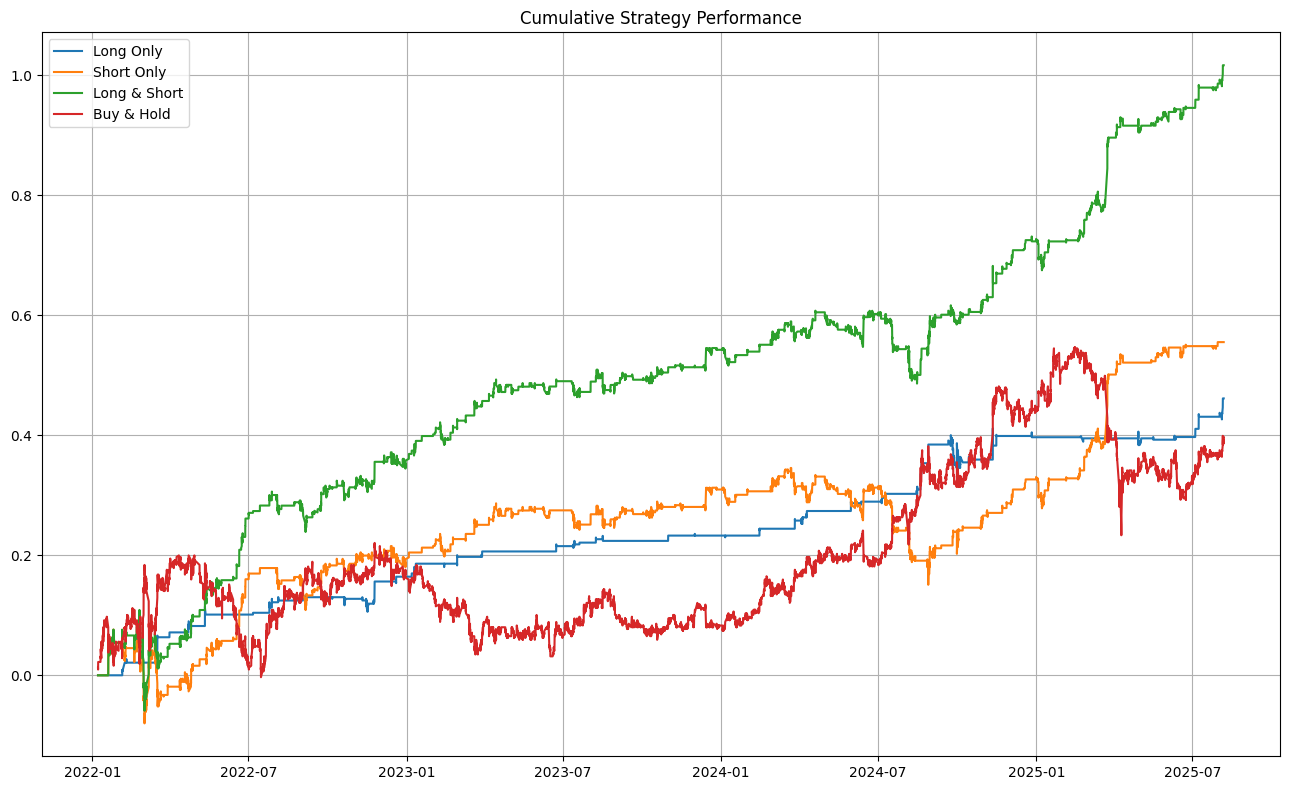

              Datetime  Open  High   Low  Close  Volume  Spread        CMO  \
0  2025-08-05 09:45:00  4.62  4.63  4.61   4.62      21      10  50.156512   
1  2025-08-05 10:00:00  4.63  4.63  4.62   4.63      32      10  53.437526   
2  2025-08-05 10:15:00  4.63  4.63  4.61   4.63      61      10  53.437526   
3  2025-08-05 10:30:00  4.63  4.66  4.63   4.65     103      10  59.669026   
4  2025-08-05 10:45:00  4.65  4.65  4.63   4.63      25      10  39.450937   
5  2025-08-05 11:00:00  4.64  4.64  4.63   4.63      29      10  39.450937   
6  2025-08-05 11:15:00  4.64  4.64  4.63   4.63      48      10  39.450937   
7  2025-08-05 11:30:00  4.63  4.63  4.63   4.63      27      10  39.450937   
8  2025-08-05 11:45:00  4.63  4.63  4.62   4.62      19      10  28.265624   
9  2025-08-05 12:00:00  4.63  4.63  4.60   4.60      56      10   9.274985   
10 2025-08-05 12:15:00  4.60  4.60  4.58   4.58      43      10  -5.829510   
11 2025-08-05 14:30:00  4.58  4.62  4.58   4.61      48      10 

In [ ]:
import time
import numpy as np
import pandas as pd
import traceback
import json
from datetime import datetime, timedelta, time as dt_time

# === STATE TRACKING ===
open_bar_index = None

# --- Robust 15-Minute Loop ---
while True:
    now = datetime.now()
    try:
        print(f"Running Analysis on {symbol}")
        run_my_analysis() # This function handles time filtering internally
        print(f"Analysis completed successfully at: {now.strftime('%Y-%m-%d %H:%M:%S')}")
    except Exception as e:
        print(f"Error occurred at: {now.strftime('%Y-%m-%d %H:%M:%S')}")
        print("Error details:")
        print(traceback.format_exc())
        
    # Calculate next 15-minute mark
    minute = (now.minute // 15 + 1) * 15
    next_run = now.replace(minute=0, second=0, microsecond=0) + timedelta(minutes=minute)
    
    # If it's already passed the hour, roll to next hour
    if minute == 60:
        next_run += timedelta(hours=1)
    
    sleep_seconds = (next_run - datetime.now()).total_seconds()
    if sleep_seconds < 0:
        sleep_seconds = 0
        
    print(f"Next run scheduled at: {next_run.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Sleeping for {sleep_seconds:.1f} seconds.\n")
    
    time.sleep(sleep_seconds)
